# RNA-Seq Analysis
## Nicole Place 
## 170503
### CSCI E-7 Graduate Project

# RNA-Seq data from: 
### Caro, F., Ahyong, V., Betegon, M. and DeRisi, J.L., 2014. Genome-wide regulatory dynamics of translation in the Plasmodium falciparum asexual blood stages. Elife, 3, p.e04106.

<p>We will analyze two stages in the Plasmodium life cycle, early trophozoite (early troph, ET) and late trophozoite (late troph, LT).</p>

### Libraries to import:

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Log transform data and plot a histogram:

### Log transforming allows the visualization of patterns in data sets that are skewed. With RNA-Seq, reads are mapped randomly accross the genome, the resulting histogram should be a Gaussian distribution. 


/Users/nicoleplace/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


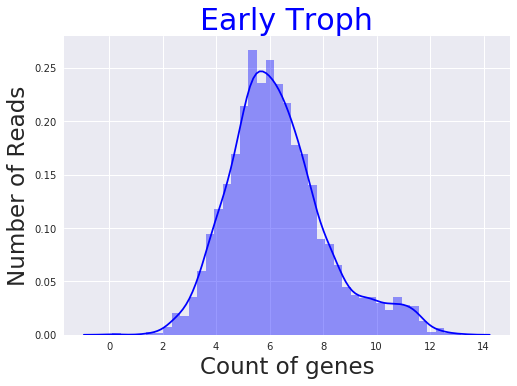

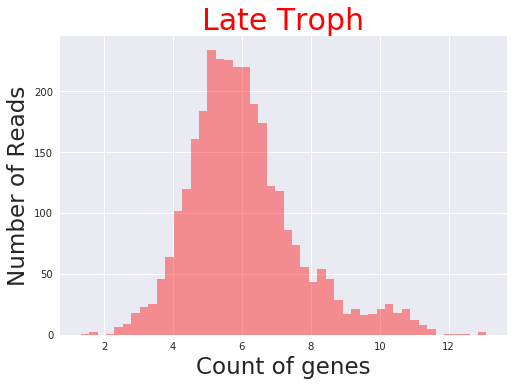

In [71]:
#Reference 2
#import data from csv file
#columns "PlasmodDB geneID", "Early troph._mRNArpkM", "Late troph._mRNArpkM" from online available data
df_raw = pd.read_csv("fig2-data1_cut.csv")

#separate two conditions, early and late troph
df_ET = df_raw[["PlasmoDB geneID","Early troph._mRNArpkM"]].copy()
df_LT = df_raw[["PlasmoDB geneID","Late troph._mRNArpkM"]].copy()

#log2 transform data, and add to new column in dataframe
df_ET["ET_log"] = np.log2(df_ET["Early troph._mRNArpkM"])
df_LT["LT_log"] = np.log2(df_LT["Late troph._mRNArpkM"])

#Drop NaN for histogram
df_ET_hist = df_ET.dropna()
df_LT_hist = df_LT.dropna()

#Reference 3
#Seaborn distribution plot for early troph
#KDE, kernal density estimation, probabilty estimate
#Change KDE, change axis label, KDE frequency, histogram counts
hist = sns.distplot(df_ET_hist["ET_log"], color = "b", kde=True)
hist.axes.set_title("Early Troph", color = "b", size = 30)
hist.set_xlabel("Count of genes", size = 23)
hist.set_ylabel("Number of Reads", size = 23)
sns.set(font="DejaVu Sans") #setting font, because error
plt.show()

#Seaborn distribution plot for early troph
hist = sns.distplot(df_LT_hist["LT_log"], color="r", kde=False)
hist.axes.set_title("Late Troph", color = "r", size = 30)
hist.set_xlabel("Count of genes", size = 23)
hist.set_ylabel("Number of Reads", size = 23)
sns.set(font="DejaVu Sans") #setting font, because error
plt.show()

In [72]:
#log transform, creating new dataframe separate from histogram data
df_raw["ET_log"] = np.log2(df_raw["Early troph._mRNArpkM"])
df_raw["LT_log"] = np.log2(df_raw["Late troph._mRNArpkM"])


#save significant to new column
#significant is greater than or less than 2 times the standard deviation, could be more or less stringent
df_raw['ET_top'] = np.where(df_raw['ET_log'] > 2*df_raw["ET_log"].std(), df_raw['ET_log'], 0)
df_raw['ET_bot'] = np.where(df_raw['ET_log'] < 2*df_raw["ET_log"].std(), df_raw['ET_log'], 0)
df_raw['LT_top'] = np.where(df_raw['LT_log'] > 2*df_raw["LT_log"].std(), df_raw['LT_log'], 0)
df_raw['LT_bot'] = np.where(df_raw['LT_log'] < 2*df_raw["LT_log"].std(), df_raw['LT_log'], 0)


#calculate mean, only 2 because either top or bottom value, not both for both conditions
df_raw["Mean"] = ((df_raw["ET_top"] + df_raw["ET_bot"] + df_raw["LT_top"] + df_raw["LT_bot"]) / 2)

#calculate mean centered value for each, mean cenetered = value - mean 
#like log transform, altering value to present trends
df_raw["LT_mc"] = (df_raw["LT_top"] + df_raw["LT_bot"] - df_raw["Mean"])
df_raw["ET_mc"] = (df_raw["ET_top"] + df_raw["ET_bot"] - df_raw["Mean"])

#Reference 4
#remove rows that contain a 0 in both early and late trophs
df_raw = df_raw[(df_raw.LT_mc != 0) & (df_raw.ET_mc != 0)]

#organize data for clustermap production 
#data log transformed rpkm, only values greater or less than 2*standard deviation, mean-centered 
df_heatmap_data = df_raw[['ET_mc', 'LT_mc']]
#labels, geneIDs
df_heatmap_labels = df_raw['PlasmoDB geneID']


#let's see what the data looks like
print("GeneID")
print(df_heatmap_labels.head())
print("Value")
print(df_heatmap_data.head())

GeneID
0     pfi0320w
2     pfc0065c
3    pf08_0001
5     pfl0895c
7    pf07_0026
Name: PlasmoDB geneID, dtype: object
Value
      ET_mc     LT_mc
0  1.034185 -1.034185
2  1.111814 -1.111814
3  3.706567 -3.706567
5  0.340106 -0.340106
7  0.027152 -0.027152


# Cluster heatmap:
### RNA expression is represented by low (green) and high (red), as a convention. Papers have been published with the reverse scheme as well. 

/Users/nicoleplace/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


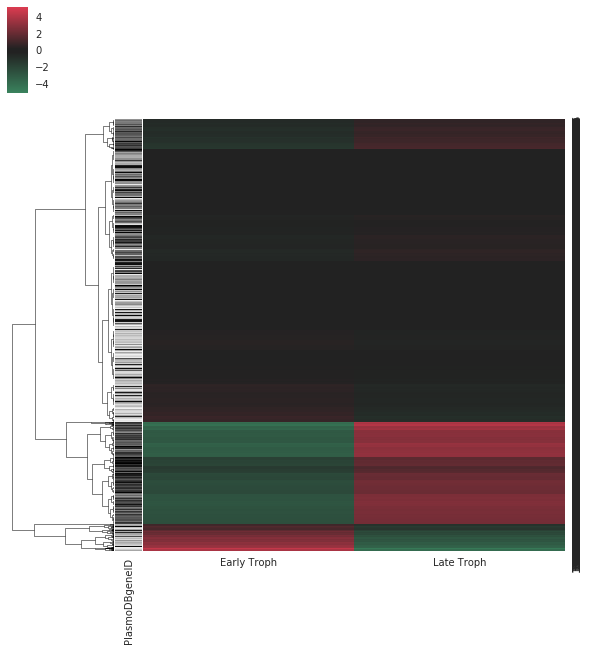

In [54]:
#data in dictionary format, easy to change name of columns
data = {'Early Troph':df_heatmap_data["ET_mc"],
        'Late Troph':df_heatmap_data["LT_mc"],
        'PlasmoDBgeneID':df_heatmap_labels}

#create dataframe of all data
#redundant as we had these in dataframes
#but easy to re-label, alter for future use
df=pd.DataFrame(data)

#Reference 5 and 6
#colormap color palette 
cmap = sns.diverging_palette(145, 8, center="dark", as_cmap = True)


#Reference 7
#color of dendrogram, with differences for geneID
ID_col = sns.light_palette('black', len(df.PlasmoDBgeneID))
ID_col_connect = dict(zip(df.PlasmoDBgeneID, ID_col))
colors = pd.Series(df.PlasmoDBgeneID).map(ID_col_connect)


sns.clustermap(df[['Early Troph', 'Late Troph']], col_cluster = False, row_colors = colors, cmap = cmap)
plt.show()